In [1]:
import sys
print(sys.version)
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue import Sheet, SheetGeometry, Monolayer, config, MonolayerGeometry
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.draw import sheet_view
from tyssue.io import hdf5

from tyssue.solvers import QSSolver
from tyssue.dynamics import model_factory, effectors

from tyssue import collisions
from tyssue.collisions.solvers import (solve_sheet_collisions,
                                       solve_bulk_collisions)
from tyssue import version
print('tyssue version: ', version.full_version)

from tyssue import config

from tyssue import stores

3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 21:52:21) 
[GCC 7.3.0]
tyssue version:  0.5.0.dev0+6df7551


## Collision avoidance

Inspired by this paper:

Liu, J.-D., Ko, M.-T., & Chang, R.-C. (1998). _A simple self-collision avoidance for cloth animation_. Computers & Graphics, 22(1), 117–128. [DOI](https://doi.org/doi:10.1016/s0097-8493(97)00087-3)


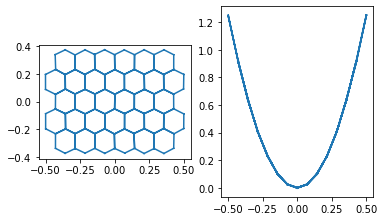

In [2]:

sheet = Sheet('crossed', hdf5.load_datasets(Path(stores.stores_dir)/"sheet6x5.hf5"))

sheet.vert_df.z = 5 * sheet.vert_df.x**2
sheet.vert_df[sheet.coords] += np.random.normal(scale=0.001, size=(sheet.Nv, 3))
    

SheetGeometry.update_all(sheet)


fig, axes = plt.subplots(1, 2, sharex=True)
fig, ax = sheet_view(sheet, coords=['x', 'y'], mode='quick', ax=axes[0])
fig, ax = sheet_view(sheet, coords=['x', 'z'], mode='quick', ax=axes[1])



In [3]:
position_buffer = sheet.vert_df[sheet.coords].copy()

sheet.vert_df.x -=  35*(sheet.vert_df.x/2)**3
SheetGeometry.update_all(sheet)

ipv.clear()
fig, mesh = sheet_view(sheet, mode='3D')
fig

/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [4]:
sheet.settings['shyness'] = 0.1
solve_sheet_collisions(sheet, position_buffer)
SheetGeometry.update_all(sheet)
ipv.clear()
sheet_view(sheet, mode='3D')
ipv.squarelim()
ipv.show()

In [5]:
datasets =  hdf5.load_datasets(Path(stores.stores_dir)/'small_ellipsoid.hf5',
                               data_names=['vert', 'edge', 'face', 'cell'])

ellipso = Monolayer(
    'ellipso', datasets,
    config.geometry.bulk_spec()
)


In [6]:
from tyssue import ClosedMonolayerGeometry, MonolayerGeometry

In [7]:
ClosedMonolayerGeometry.update_all(ellipso)

In [8]:
ipv.clear()
sheet_view(ellipso, mode='3D', face={"visible": True, "color": ellipso.face_df.area})
ipv.squarelim()
ipv.show()

In [10]:
position_buffer = ellipso.vert_df[ellipso.coords]
solve_bulk_collisions(ellipso, position_buffer)

False

In [11]:
ellipso

In [38]:
idx = ellipso.face_df.index.get_indexer(ellipso.edge_df['face'])


%timeit a = ellipso.face_df['area'].take(idx)

%timeit a = ellipso.upcast_face("area")

123 µs ± 2.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
177 µs ± 1.37 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%timeit a = ellipso.face_df['area'].take(idx)

%timeit a = ellipso.upcast_face("area")

123 µs ± 700 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
178 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
import numpy as np, pandas as pd
import ipyvolume as ipv
import matplotlib.pyplot as plt
%matplotlib inline

from tyssue import Epithelium, Monolayer
from tyssue import MonolayerGeometry
from tyssue import Sheet, SheetGeometry
from tyssue.config.geometry import bulk_spec
from tyssue.generation import three_faces_sheet
from tyssue.generation import extrude
from tyssue.draw import sheet_view, highlight_cells

from tyssue.topology.bulk_topology import IH_transition, HI_transition

from tyssue import Sheet, SheetGeometry, Monolayer, config, MonolayerGeometry
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.draw import sheet_view
from tyssue.io import hdf5

from tyssue.solvers import QSSolver
from tyssue.dynamics import model_factory, effectors

from tyssue import collisions
from tyssue.collisions.solvers import (solve_sheet_collisions,
                                       solve_bulk_collisions)
from tyssue import version
print('tyssue version: ', version.full_version)

from tyssue import config

from tyssue import stores




tyssue version:  0.5.0.dev0+6df7551


In [16]:
draw_spec = {'face': {'visible': True}}

sheet = Sheet.planar_sheet_3d('sheet', 5, 5, 1, 1)
sheet.sanitize(trim_borders=True)
SheetGeometry.center(sheet)
datasets = extrude(sheet.datasets, method='translation')

eptm = Monolayer('20faces_3D', datasets, bulk_spec())

MonolayerGeometry.update_all(eptm)
ipv.clear()

sheet_view(
    eptm, mode='3D',
    face={"visible": True,
          "color": eptm.face_df.area}
)

ipv.squarelim()
ipv.show()

In [17]:
from tyssue.draw.plt_draw import plot_forces
from tyssue.solvers import QSSolver

geom = ClosedMonolayerGeometry
eptm = ellipso
i = 0

class Compression(effectors.AbstractEffector):

    label = "Compression"
    element = "vert"  # cell, face, edge or vert
    specs = {
        "vert": {
            "compression": 0
        },
        "settings":{
            "compression_axis":"x"
        }
    }

    @staticmethod
    def energy(eptm):
        ax = eptm.settings.get("compression_axis", "x")
        return eptm.vert_df.eval(f"0.5 * compression * {ax}**2")
        
    @staticmethod
    def gradient(eptm):
        ax = eptm.settings.get("compression_axis", "x")
        grad = pd.DataFrame(
            np.zeros((eptm.Nv, 3)),
            index=eptm.vert_df.index,
            columns=["gx", "gy", "gz"])
        grad['gx'] = eptm.vert_df.eval(f"compression * {ax}")
        return grad, None
        

model = model_factory([
    Compression,
    effectors.SurfaceTension,
    effectors.CellAreaElasticity,
    effectors.CellVolumeElasticity
    ],effectors.CellVolumeElasticity)

dyn_specs = {
    "vert": {
        "compression": 0., #1e-3,
    },
    "face": {
        "surface_tension": 1e-3,
    },
    "edge": {
        "ux": 0,
        "uy": 0,
        "uz": 0,
        "line_tension": 0.01,
    },
    "cell": {
        "prefered_vol" : eptm.cell_df.vol.mean(),
        "vol_elasticity" : 1,
        "prefered_area" : eptm.cell_df.area.mean(),
        "area_elasticity" : 1,
    }
}

eptm.update_specs(dyn_specs)
eptm.face_df.loc[eptm.apical_faces, "surface_tension"] = 1e-2
eptm.face_df.loc[eptm.basal_faces, "surface_tension"] = 1e-2

eptm.reset_topo()
U = model.compute_gradient(eptm)




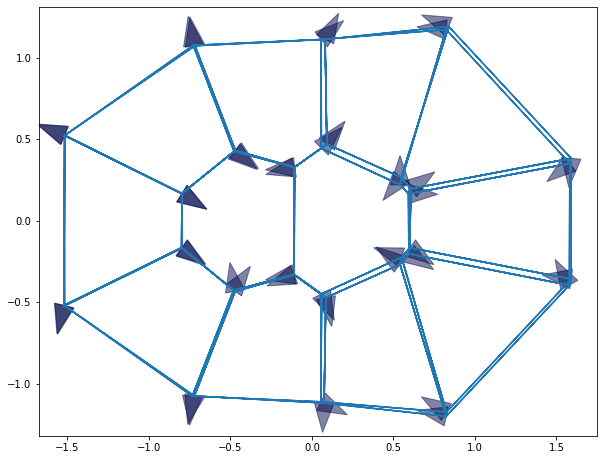

In [19]:
fig, ax = plot_forces(eptm, geom, model, coords=list("xy"), scaling=1)
fig.set_size_inches(10, 10)

In [5]:
%pdb

Automatic pdb calling has been turned ON


In [20]:
eptm.settings['threshold_length'] = 1e-2
solver = QSSolver(with_collisions=False, with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)

In [21]:
eptm.settings['threshold_length'] = 1e-2
eptm.settings['shyness'] = 1.2e-2
solver = QSSolver(with_collisions=True, with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)

In [22]:
eptm_bck = eptm.copy()

In [23]:
eptm = eptm_bck.copy()
eptm.vert_df.loc[eptm.apical_verts, "compression"] = 0.2
eptm.vert_df.loc[eptm.basal_verts, "compression"] = 0.01


In [10]:
np.all(np.isfinite(eptm.vert_df[eptm.coords]))

True

In [24]:
eptm.settings['shyness'] = 2e-1
eptm.settings['thershold_length'] = 1e-2

solver = QSSolver(with_collisions=True, with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
print(res['message'])


b'ABNORMAL_TERMINATION_IN_LNSRCH'


In [12]:
eptmb = eptm.copy()

eptmb.vert_df[eptm.coords] = eptm.position_buffer

In [29]:
pairs = np.array([[10,  4],
       [ 8,  9],
       [ 6,  7],
       [ 0,  2],
       [ 0,  1],
       [ 8, 10],
       [ 5,  6],
       [ 8,  6],
       [ 2,  7],
       [ 9,  5],
       [ 4,  7]]).ravel()

In [30]:
    %pdb

Automatic pdb calling has been turned OFF


In [36]:
ipv.clear()

eptm.face_df['visible'] = True

sheet_view(
    eptm, mode='3D',
    face={"visible": False,
          "color": eptm.face_df.area}
)



ipv.squarelim()
ipv.show()

In [37]:
solver = QSSolver(with_collisions=False, with_t1=False, with_t3=False)
res = solver.find_energy_min(eptm, geom, model)
print(res['message'])


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [ ]:
eptm.topo_changed

In [15]:
eptm.validate()

True

In [22]:
eptm.edge_df.length.min()

0.002063248202297611

In [ ]:
solve_bulk_collisions(eptm, eptm.position_buffer)

ValueError: Plane Not Found

> /home/guillaume/miniconda3/lib/python3.7/site-packages/tyssue-0.3.3rc1-py3.7-linux-x86_64.egg/tyssue/collisions/solvers.py(264)_collision_plane()
    262             ]
    263         else:
--> 264             raise ValueError("""Plane Not Found""")
    265             log.warning("""Plane Not Found""")
    266             self.plane_not_found = True

ipdb> sign_change_l0h1
x    False
y    False
z    False
dtype: bool
ipdb> sign_change_l1h1
*** NameError: name 'sign_change_l1h1' is not defined
ipdb> sign_change_l1h0
x    False
y    False
z    False
dtype: bool
ipdb> self.sheet.position_buffer
ipdb> self.position_buffer
*** AttributeError: 'CollidingBoxes' object has no attribute 'position_buffer'
ipdb> position_buffer
*** NameError: name 'position_buffer' is not defined


In [17]:
from tyssue.collisions.solvers import self_intersections, CollidingBoxes, _face_bbox, solve_bulk_collisions
from tyssue.core.sheet import get_outer_sheet

position_buffer = eptm.position_buffer.copy()


sub_sheet = get_outer_sheet(eptm)
pos_idx = sub_sheet.vert_df.index.copy()
sub_sheet.reset_index()
sub_buffer = pd.DataFrame(
    position_buffer.loc[pos_idx].values,
    index=sub_sheet.vert_df.index,
    columns=sub_sheet.coords,
)


intersecting_edges = self_intersections(sub_sheet)

boxes = CollidingBoxes(sub_sheet, sub_buffer, intersecting_edges)

boxes.face_pairs

array([[10,  4],
       [ 8,  9],
       [ 6,  7],
       [ 0,  2],
       [ 0,  1],
       [ 8, 10],
       [ 5,  6],
       [ 8,  6],
       [ 2,  7],
       [ 9,  5],
       [ 4,  7]])

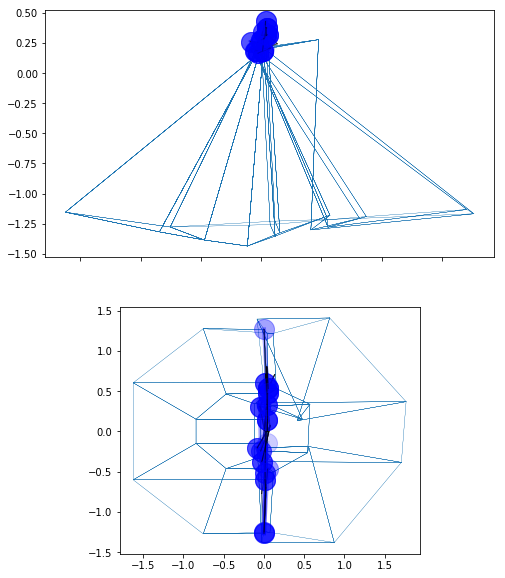

In [18]:
fig, (ax1, ax) = plt.subplots(2, 1, sharex=True)


fig, ax1 = sheet_view(
    eptm,
    coords=list("xz"),
    mode="quick",
    edge={"lw": 0.2},
    ax=ax1)
fig.set_size_inches(10, 10)

for i, e in sub_sheet.edge_df.loc[boxes.edge_pairs.ravel()].iterrows():
    
    ax1.plot(e.loc[["sx", "tx"]].values, e.loc[["sz", "tz"]], "b-o", ms=20, lw=4, alpha=0.2)
    ax1.plot(e.loc[["fx", "sx"]].values, e.loc[["fz", "sz"]], "k-", ms=20, lw=1, alpha=0.5)
    ax1.plot(e.loc[["fx", "tx"]].values, e.loc[["fz", "tz"]], "k-", ms=20, lw=1, alpha=0.5)



fig.set_size_inches(20, 10)

fig, ax = sheet_view(
    eptm,
    coords=list("xy"),
    mode="quick",
    edge={"lw": 0.2},
    ax=ax
    )

for i, e in sub_sheet.edge_df.loc[boxes.edge_pairs.ravel()].iterrows():
    
    ax.plot(e.loc[["sx", "tx"]].values, e.loc[["sy", "ty"]], "b-o", ms=20, lw=4, alpha=0.2)
    ax.plot(e.loc[["fx", "sx"]].values, e.loc[["fy", "sy"]], "k-", ms=20, lw=1, alpha=0.5)
    ax.plot(e.loc[["fx", "tx"]].values, e.loc[["fy", "ty"]], "k-", ms=20, lw=1, alpha=0.5)




In [20]:
face_pair = 169, 182

In [21]:
self = boxes
shyness = 1e-2

In [22]:
f0, f1 = boxes.face_pairs[0]

fe0c = self.sheet.edge_df[self.sheet.edge_df["face"] == f0].copy()
fe1c = self.sheet.edge_df[self.sheet.edge_df["face"] == f1].copy()
fe0p = self.edge_buffer[self.sheet.edge_df["face"] == f0].copy()
fe1p = self.edge_buffer[self.sheet.edge_df["face"] == f1].copy()


In [23]:
bb0c = _face_bbox(fe0c)
bb1c = _face_bbox(fe1c)
bb0p = _face_bbox(fe0p)
bb1p = _face_bbox(fe1p)


In [25]:
dr0 = bb0c - bb0p
dr1 = bb1c - bb1p
sign_change_l1h0 = np.sign((bb1c.l - bb0c.h) * (bb1p.l - bb0p.h)) < 0
sign_change_l0h1 = np.sign((bb0c.l - bb1c.h) * (bb0p.l - bb1p.h)) < 0


In [26]:
sign_change_l0h1

x     True
y    False
z    False
dtype: bool

In [27]:
sign_change_l1h0

x    False
y    False
z    False
dtype: bool

In [24]:
shyness = 0.1

lower_bound = pd.DataFrame(
    index=pd.concat((fe0c.srce, fe1c.srce)), columns=list("xyz")
)
upper_bound = pd.DataFrame(
    index=pd.concat((fe0c.srce, fe1c.srce)), columns=list("xyz")
)
for c in list("xyz"):
    b0 = bb0c.loc[c]
    b1 = bb1c.loc[c]
    left, right = (fe0c, fe1c) if (b0.mean() < b1.mean()) else (fe1c, fe0c)

    lim = (left[f"s{c}"].max() + right[f"s{c}"].min()) / 2
    upper_bound.loc[left.srce, c] = lim - shyness / 2
    upper_bound.loc[right.srce, c] = right[f"s{c}"].max()

    lower_bound.loc[right.srce, c] = lim + shyness / 2
    lower_bound.loc[left.srce, c] = left[f"s{c}"].min()
        
    

In [53]:
right.sx


edge
12   -0.069227
20   -0.069235
27    0.097498
36    0.399908
38    0.105875
41    0.700321
Name: sx, dtype: float64

In [51]:
bb0c

,l,h
x,-0.069235,0.700321
y,-0.449709,0.455829
z,0.153990,0.366268


In [47]:
left.srce

edge
24     14
30     37
39     13
42     39
145    36
147    38
Name: srce, dtype: int64

In [ ]:
right

In [54]:
upper_bound

,x,y,z
srce,,,
10,0.417915,0.455829,0.366268
4,0.417915,0.455829,0.366268
11,0.417915,0.455829,0.366268
39,1.477,0.455829,0.366268
17,0.417915,0.455829,0.366268
36,1.477,0.455829,0.366268
14,1.477,-0.104798,0.151229
37,1.477,-0.104798,0.151229
13,1.477,-0.104798,0.151229


In [109]:
fe0c.sx

edge
18    -5.546031
22    -5.046683
159   -5.490565
162   -4.546923
164   -4.546263
165   -4.867467
Name: sx, dtype: float64

In [70]:
bb1c

,l,h,c
x,-6.704158,-5.482137,-6.093147
y,5.467833,6.825194,6.146513
z,-0.024543,0.031226,0.003342


In [72]:
boxes._collision_plane(face_pair, 0.01)

ValueError: The collision was already present or its axis could not be determined

In [ ]:
for coord in list("xyz"):
    
    